# Featurizing the whole cell  covariance matrix as features
Alyssa's 12/12/2018

Currently, we are only adding the covariance matrix  for distances between the query cell type and the cell types in train. In this experiment, we add in the similarities between cell types in the train set and see if it helps

# Imports

In [1]:
import collections
import datetime

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from scipy import stats

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

In [ ]:
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
# Required in constants.py
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

# where training data is stored
deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"

# Define Paths for this user

In [4]:


exec(open("./constants.py").read())
exec(open("./functions.py").read())
exec(open("./generators.py").read())
exec(open("./models.py").read())

# Load Data

### Load DeepSEA data

In [7]:
# TODO spead this up
deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"

train_data, valid_data, test_data = load_deepsea_data(deepsea_path)


In [8]:
print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4455024, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4455024) (919, 455024)


# Validation and Test Cell Types

In [9]:
# Available cell types
validation_celltypes = ["K562", "HepG2"] 
test_celltypes = ["A549"]


## Get matrix of cell types and assays

['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] ['DNase', 'p300', 'c-Myc', 'c-Jun', 'ZBTB33', 'YY1', 'USF2', 'USF-1', 'TBP', 'TAF1', 'Rad21', 'RFX5', 'Pol2-4H8', 'Pol2', 'NRSF', 'Max', 'GABP', 'EZH2', 'CTCF', 'CEBPB']


{'DNase': 0,
 'p300': 1,
 'c-Myc': 2,
 'c-Jun': 3,
 'ZBTB33': 4,
 'YY1': 5,
 'USF2': 6,
 'USF-1': 7,
 'TBP': 8,
 'TAF1': 9,
 'Rad21': 10,
 'RFX5': 11,
 'Pol2-4H8': 12,
 'Pol2': 13,
 'NRSF': 14,
 'Max': 15,
 'GABP': 16,
 'EZH2': 17,
 'CTCF': 18,
 'CEBPB': 19}

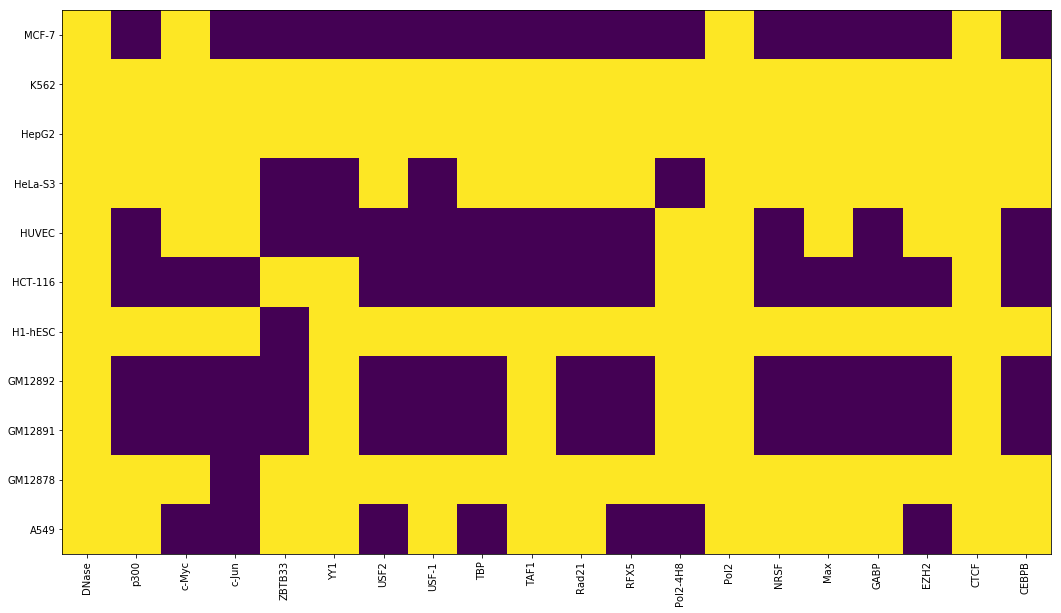

In [12]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', eligible_assays = DEFAULT_ASSAYS, 
                                 eligible_cells = DEFAULT_CELLS)
        
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys()), list(assaymap.keys()))


label_assays = list(assaymap)
assaymap

# Define New Covariance Generator

In [50]:

def gen_from_peaks_covariance(data, y_index_vectors, assay_indices, dnase_indices, indices, radii, **kwargs):
    """
    Takes Deepsea data and calculates distance metrics from cell types whose locations
    are specified by y_index_vector, and the other cell types in the set. Label space is only one assay.
    This generator is used to test single vs multilabel classification performance.
    
    :param data: dictionary of matrices. Should have keys x and y. x contains n by 1000 rows. y contains n y 919 labels.
    :param y_index_vectors: list of vectors which the indices in the y labels that should be used. 
    :param assay_indices: list of assays that should be used in the label space.
    :param dnase_indices: indices for DNase for celltypes
    :param indices: indices of cell types for the feature space (does not include cell types for eval/test)
    :param radii: where to calculate DNase similarity to.
    
    :returns: generator of data
    """
    # y indices for x and assay indices for y should have the same length
    assert len(y_index_vectors) == len(assay_indices), "Length of y_index_vectors and assay_indices must be the same (# cells evaluatated)"
    
    def g():
                    
        if (len(radii) > 0):
            range_ = range(max(radii), data["y"].shape[-1]-max(radii))
        else: 
            range_ = range(0, data["y"].shape[-1])
 
        for i in range_: # for all records
        
            train_dnases = []
            
            for j in dnase_indices:
                for radius in radii:
                    # calculate dnase similarities for all dnases in the train set
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                                     data["y"][j,i-radius:i+radius+1], axis=1)

                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                                     data["y"][j,i-radius:i+radius+1], axis=1)

                    train_dnases.extend(dnase_double_positive)
                    train_dnases.extend(dnase_agreement)

            
            for (y_index, assay_index) in zip(y_index_vectors, assay_indices): # for all validation cell types
                dnases = train_dnases.copy()
            
                for radius in radii:
                    # within the radius, fraction of places where they are both 1
                    # y_index[0] == DNase location for specific cell type
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    
                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                    
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                assay_index_no_dnase = np.delete(assay_index, [0])
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][assay_index_no_dnase,i] 
    return g


# Run the Model

In [51]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())
exec(open("./generators.py").read())
exec(open("./models.py").read())

In [60]:
model = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            validation_celltypes,
            test_celltypes,
            gen_from_peaks_covariance, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            label_assays = label_assays,
            radii=[1,3,10,30])
model.train(20000)


INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 1.3487173
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.7761467441809216
INFO:tensorflow:Our micro AUC:     0.8332269192193255
2018-12-12 07:32:10.489831 0 DNase
INFO:tensorflow:2018-12-12 07:32:10.489926: 0, DNase, NaN
INFO:tensorflow:2018-12-12 07:32:10.490624: 1, p300, 0.586627
INFO:tensorflow:2018-12-12 07:32:10.505091: 2, c-Myc, 0.842369
INFO:tensorflow:2018-12-12 07:32:10.518599: 3, c-Jun, 0.834630
INFO:tensorflow:2018-12-12 07:32:10.532064: 4, ZBTB33, 0.684817
INFO:tensorflow:2018-12-12 07:32:10.545546: 5, YY1, 0.885146
INFO:tensorflow:2018-12-12 07:32:10.559076: 6, USF2, 0.591814
INFO:tensorflow:2018-12-12 07:32:10.572534: 7, USF-1, 0.763633
INFO:tensorflow:2018-12-12 07:32:10.586042: 8, TBP, 0.749331
INFO:tensorflow:2018-12-12 07:32:10.599735: 9, TAF1, 0.908061
INFO:tensorflow:2018-12-12 07:32:10.613301: 10, Rad21, 0.971971
INFO:tensorflow:2018-12-12 07:32:10.6267

INFO:tensorflow:2018-12-12 07:45:43.805398: 9, TAF1, 0.981846
INFO:tensorflow:2018-12-12 07:45:43.818612: 10, Rad21, 0.978330
INFO:tensorflow:2018-12-12 07:45:43.831916: 11, RFX5, 0.910878
INFO:tensorflow:2018-12-12 07:45:43.845047: 12, Pol2-4H8, 0.941811
INFO:tensorflow:2018-12-12 07:45:43.858323: 13, Pol2, 0.945566
INFO:tensorflow:2018-12-12 07:45:43.871652: 14, NRSF, 0.947205
INFO:tensorflow:2018-12-12 07:45:43.884928: 15, Max, 0.929456
INFO:tensorflow:2018-12-12 07:45:43.898346: 16, GABP, 0.961937
INFO:tensorflow:2018-12-12 07:45:43.911520: 17, EZH2, 0.740103
INFO:tensorflow:2018-12-12 07:45:43.924637: 18, CTCF, 0.967137
INFO:tensorflow:2018-12-12 07:45:43.937918: 19, CEBPB, 0.742208
INFO:tensorflow:
INFO:tensorflow:7000 0.16981806
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8899353849884926
INFO:tensorflow:Our micro AUC:     0.9207228766420028
2018-12-12 07:48:21.102927 0 DNase
INFO:tensorflow:2018-12-12 07:48:21.103027: 0, DNase, NaN
INFO:tensorflow:2018-12

INFO:tensorflow:Our micro AUC:     0.9221444167724094
2018-12-12 08:02:10.111871 0 DNase
INFO:tensorflow:2018-12-12 08:02:10.111966: 0, DNase, NaN
INFO:tensorflow:2018-12-12 08:02:10.112848: 1, p300, 0.902085
INFO:tensorflow:2018-12-12 08:02:10.127292: 2, c-Myc, 0.951479
INFO:tensorflow:2018-12-12 08:02:10.140567: 3, c-Jun, 0.802888
INFO:tensorflow:2018-12-12 08:02:10.153796: 4, ZBTB33, 0.915769
INFO:tensorflow:2018-12-12 08:02:10.167087: 5, YY1, 0.944409
INFO:tensorflow:2018-12-12 08:02:10.180369: 6, USF2, 0.910764
INFO:tensorflow:2018-12-12 08:02:10.193641: 7, USF-1, 0.864709
INFO:tensorflow:2018-12-12 08:02:10.207002: 8, TBP, 0.927658
INFO:tensorflow:2018-12-12 08:02:10.220391: 9, TAF1, 0.967811
INFO:tensorflow:2018-12-12 08:02:10.233630: 10, Rad21, 0.977209
INFO:tensorflow:2018-12-12 08:02:10.246884: 11, RFX5, 0.952088
INFO:tensorflow:2018-12-12 08:02:10.260172: 12, Pol2-4H8, 0.869654
INFO:tensorflow:2018-12-12 08:02:10.281971: 13, Pol2, 0.936968
INFO:tensorflow:2018-12-12 08:02:10

INFO:tensorflow:2018-12-12 08:18:20.206477: 12, Pol2-4H8, 0.897790
INFO:tensorflow:2018-12-12 08:18:20.219653: 13, Pol2, 0.888480
INFO:tensorflow:2018-12-12 08:18:20.232797: 14, NRSF, 0.920832
INFO:tensorflow:2018-12-12 08:18:20.246075: 15, Max, 0.916243
INFO:tensorflow:2018-12-12 08:18:20.259411: 16, GABP, 0.950484
INFO:tensorflow:2018-12-12 08:18:20.272545: 17, EZH2, 0.900808
INFO:tensorflow:2018-12-12 08:18:20.285631: 18, CTCF, 0.979650
INFO:tensorflow:2018-12-12 08:18:20.298941: 19, CEBPB, 0.706644
INFO:tensorflow:
INFO:tensorflow:18000 1.0112327
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8810923146880864
INFO:tensorflow:Our micro AUC:     0.9068570584198822
2018-12-12 08:20:55.558146 0 DNase
INFO:tensorflow:2018-12-12 08:20:55.558242: 0, DNase, NaN
INFO:tensorflow:2018-12-12 08:20:55.558961: 1, p300, 0.857002
INFO:tensorflow:2018-12-12 08:20:55.573577: 2, c-Myc, 0.936101
INFO:tensorflow:2018-12-12 08:20:55.587071: 3, c-Jun, 0.754012
INFO:tensorflow:2018-12-

In [62]:
test_DNase = model.test(455024, mode = Dataset.TEST, log=True)


# INFO:tensorflow:2018-12-05 12:19:02.977124: 0, DNase, NaN
# INFO:tensorflow:2018-12-05 12:19:02.979063: 1, Rad21, 0.936362
# INFO:tensorflow:2018-12-05 12:19:03.135981: 2, CTCF, 0.972709
# INFO:tensorflow:2018-12-05 12:19:03.300613: 3, SMC3, 0.905783

INFO:tensorflow:Our macro AUC:     0.9296935691916315
INFO:tensorflow:Our micro AUC:     0.925227248470242
2018-12-12 09:19:15.661346 0 DNase
INFO:tensorflow:2018-12-12 09:19:15.661497: 0, DNase, NaN
INFO:tensorflow:2018-12-12 09:19:15.662247: 1, p300, 0.906875
2018-12-12 09:19:15.823545 2 c-Myc
INFO:tensorflow:2018-12-12 09:19:15.823635: 2, c-Myc, NaN
2018-12-12 09:19:15.824318 3 c-Jun
INFO:tensorflow:2018-12-12 09:19:15.824533: 3, c-Jun, NaN
INFO:tensorflow:2018-12-12 09:19:15.825238: 4, ZBTB33, 0.925065
INFO:tensorflow:2018-12-12 09:19:15.982702: 5, YY1, 0.933539
2018-12-12 09:19:16.139397 6 USF2
INFO:tensorflow:2018-12-12 09:19:16.139480: 6, USF2, NaN
INFO:tensorflow:2018-12-12 09:19:16.140103: 7, USF-1, 0.939744
2018-12-12 09:19:16.297874 8 TBP
INFO:tensorflow:2018-12-12 09:19:16.297975: 8, TBP, NaN
INFO:tensorflow:2018-12-12 09:19:16.298623: 9, TAF1, 0.914989
INFO:tensorflow:2018-12-12 09:19:16.454560: 10, Rad21, 0.991681
2018-12-12 09:19:16.611630 11 RFX5
INFO:tensorflow:2018-12